# Differential Peak Shape Analysis

**Created**: 27 April 2022

## Environment

In [1]:
import collections
import os

import numpy as np
import pandas as pd
import pyBigWig
import matplotlib.pyplot as plt
from matplotlib import gridspec

## Load Data

In [2]:
ds_peaks = pd.read_csv('/nfs/users/nfs_n/nm18/gains_team282/epigenetics/regulation/immune/ds_peaks.csv')

In [3]:
ds_peaks.head()

,Cell.Type,Peak.ID,Peak.Chr,Peak.Start,Peak.End,logFC,AveExpr,t,P.Value,adj.P.Val,B
0,Monocytes,3:71039134-71039950,3,71039134,71039950,-0.004960,0.006836,-10.111862,1.889271e-17,1.339645e-12,27.881030
1,Monocytes,2:127700231-127702928,2,127700231,127702928,0.013753,0.007923,9.740248,1.364789e-16,4.838724e-12,25.906231
2,Monocytes,16:11223876-11226697,16,11223876,11226697,-0.006798,0.007307,-9.527267,4.230839e-16,1.000001e-11,24.776959
3,Monocytes,11:67435597-67437988,11,67435597,67437988,0.004888,0.006810,9.329019,1.210579e-15,2.145994e-11,23.728108
4,Monocytes,16:67109014-67111194,16,67109014,67111194,-0.005288,0.006861,-8.414829,1.486217e-13,2.107693e-09,18.935435


In [4]:
metadata = pd.read_csv('/nfs/users/nfs_n/nm18/eQTL_pQTL_Characterization/03_Functional_Interpretation/metadata/reads_atac_seq.txt')

In [5]:
metadata.head()

,Run,Group.ID,Sample.ID,Donor,Lineage,Cell_type,Stimulated,Treatment,Replicate,Assay.Type,...,Experiment,Instrument,LibraryLayout,LibrarySelection,LibrarySource,Organism,Platform,ReleaseDate,Sample.Name,SRA.Study
0,SRR2920475,Corces-4983-Monocytes-Control,Corces-4983-Monocytes-Control-1,Corces-4983,MYELOID,Monocytes,False,Control,1,ATAC-Seq,...,SRX1427798,NextSeq 500,PAIRED,other,GENOMIC,Homo sapiens,ILLUMINA,2016-06-01T00:00:00Z,GSM1937385,SRP066100
1,SRR2920488,Corces-6792-Monocytes-Control,Corces-6792-Monocytes-Control-1,Corces-6792,MYELOID,Monocytes,False,Control,1,ATAC-Seq,...,SRX1427811,NextSeq 500,PAIRED,other,GENOMIC,Homo sapiens,ILLUMINA,2016-06-01T00:00:00Z,GSM1937398,SRP066100
2,SRR2920476,Corces-4983-Monocytes-Control,Corces-4983-Monocytes-Control-2,Corces-4983,MYELOID,Monocytes,False,Control,2,ATAC-Seq,...,SRX1427799,NextSeq 500,PAIRED,other,GENOMIC,Homo sapiens,ILLUMINA,2016-06-01T00:00:00Z,GSM1937386,SRP066100
3,SRR2920487,Corces-6792-Monocytes-Control,Corces-6792-Monocytes-Control-2,Corces-6792,MYELOID,Monocytes,False,Control,2,ATAC-Seq,...,SRX1427810,NextSeq 500,PAIRED,other,GENOMIC,Homo sapiens,ILLUMINA,2016-06-01T00:00:00Z,GSM1937397,SRP066100
4,SRR2920542,Corces-7256-Monocytes-Control,Corces-7256-Monocytes-Control-1,Corces-7256,MYELOID,Monocytes,False,Control,1,ATAC-Seq,...,SRX1427865,NextSeq 500,PAIRED,other,GENOMIC,Homo sapiens,ILLUMINA,2016-06-01T00:00:00Z,GSM1937452,SRP066100


## Load Fiedler Vectors

The Pandas `read_csv` function is very slow with large CSV files. Since I know that the shape features are in a well-formed CSV file, I wrote my own function to quickly read the file with minimal checks.

In [6]:
def load_fiedler_vectors():

    consensus_file = '/nfs/users/nfs_n/nm18/gains_team282/epigenetics/regulation/immune/shape_features/consensus_shape_features.csv'
    
    data = collections.defaultdict(list)
    
    with open(consensus_file, 'r') as f_in:
        
        header = f_in.readline().strip().split(',')
        
        line = f_in.readline().strip()
        
        while line:
            
            line_elements = line.split(',')
        
            for i in range(len(header)):
                data[header[i]].append(line_elements[i])
            
            line = f_in.readline().strip()
        
    df = pd.DataFrame(data)
    df = df.set_index('Sample')
    df = df.astype(float)
    
    return df

In [7]:
fiedler_vectors = load_fiedler_vectors()

In [8]:
fiedler_vectors.head()

,1:804821-805016,1:812642-812879,1:815224-815554,1:817057-817622,1:819712-820327,1:821473-823221,1:826611-827935,1:838089-838609,1:840615-840851,1:842737-843033,...,X:155850897-155851144,X:155862338-155862667,X:155876786-155876963,X:155877337-155877633,X:155880556-155882240,X:155888212-155888502,X:155898696-155899182,X:155899277-155899571,X:155956186-155956393,X:155966976-155967132
Sample,,,,,,,,,,,,,,,,,,,,,
Calderon-1001-Bulk_B-Control,0.006027,0.009348,0.006483,0.005225,0.005646,0.005222,0.008072,0.005701,-0.005971,-0.001110,...,0.003910,0.001912,-0.006164,0.006494,-0.006918,-0.001980,0.005025,0.004798,0.006499,-0.004604
Calderon-1001-Bulk_B-Treatment_1,0.006338,0.009348,0.005662,0.003848,0.006003,0.004948,0.005937,0.006315,-0.019856,-0.000931,...,0.005185,-0.000907,-0.006182,0.006032,-0.006704,-0.001612,0.005078,0.006144,0.005089,-0.005050
Calderon-1001-CD8pos_T-Control,0.005776,0.010871,0.006417,0.006853,0.006026,0.005826,0.006894,0.005579,-0.002241,-0.002696,...,0.005185,0.005088,-0.009891,0.005154,-0.005884,-0.005191,0.005775,0.005086,0.007590,-0.005318
Calderon-1001-CD8pos_T-Treatment_1,0.006563,0.010616,0.005662,0.006839,0.006016,0.005463,0.006096,0.005831,-0.004953,-0.000427,...,0.005185,0.000352,-0.005447,0.006694,-0.005802,-0.005313,0.004990,0.005156,0.007595,-0.006094
Calderon-1001-Central_memory_CD8pos_T-Control,0.006545,0.009348,0.005662,0.005529,0.006030,0.006578,0.005892,0.004764,-0.007015,-0.003540,...,0.008196,-0.000733,-0.010841,0.005802,-0.006004,-0.005792,0.006497,0.004610,0.007413,-0.005060


## Top Peaks in Monocytes

In [9]:
samples = metadata[metadata['Group.ID'].str.contains('Calderon') | metadata['Group.ID'].str.contains('Corces')]['Group.ID'].tolist()

In [72]:
cell_peaks = ds_peaks[ds_peaks['Cell.Type'] == 'Mature_NK']

cell_peaks.iloc[
    np.argsort(cell_peaks['Peak.End'] - cell_peaks['Peak.Start']),
    :
].iloc[::-1, :]

,Cell.Type,Peak.ID,Peak.Chr,Peak.Start,Peak.End,logFC,AveExpr,t,P.Value,adj.P.Val,B
24362,Mature_NK,19:14439001-14441996,19,14439001,14441996,-0.079634,-0.005240,-5.492500,2.524741e-07,0.000268,4.650282
24368,Mature_NK,1:226696612-226699600,1,226696612,226699600,-0.002770,-0.005549,-5.415249,3.557678e-07,0.000268,4.314791
25744,Mature_NK,19:58345492-58348475,19,58345492,58348475,0.001407,-0.005584,4.198198,5.432090e-05,0.002705,-0.563000
25936,Mature_NK,5:76849359-76852338,5,76849359,76852338,-0.004723,0.005233,-3.846419,2.000134e-04,0.008776,-1.809202
25670,Mature_NK,9:122120690-122123657,9,122120690,122123657,-0.012365,-0.006889,-4.354218,2.977172e-05,0.001564,0.015157
...,...,...,...,...,...,...,...,...,...,...,...
24502,Mature_NK,11:59053234-59053731,11,59053234,59053731,-0.230632,0.000482,-4.994144,2.202429e-06,0.000268,2.536519
25087,Mature_NK,9:136769722-136770200,9,136769722,136770200,-0.255538,0.000558,-4.894081,3.355349e-06,0.000268,2.127218
24885,Mature_NK,12:7806826-7807275,12,7806826,7807275,0.256205,-0.000609,4.905476,3.199070e-06,0.000268,2.173561
24891,Mature_NK,12:57086136-57086519,12,57086136,57086519,-0.256433,0.000501,-4.905218,3.202525e-06,0.000268,2.172512


In [98]:
peak_idx = 24362
chrom = ds_peaks.loc[peak_idx, 'Peak.Chr']
start = ds_peaks.loc[peak_idx, 'Peak.Start']
end = ds_peaks.loc[peak_idx, 'Peak.End']

In [99]:
sample_dir = '/nfs/users/nfs_n/nm18/gains_team282/epigenetics/accessibility/merged/atac_seq/'

region = list()

for sample in samples:
    
    bw_file = pyBigWig.open(os.path.join(sample_dir, sample, 'alignment', f'{sample}.bw'))

    values = np.array(bw_file.values(chrom, start, end))

    values[np.isnan(values)] = 0

    if values.sum() > 0:
        values = values / values.sum()
    else:
        values = np.array([1 / (end - start)] * (end - start))

    region.append(values)
    
distribution = np.vstack(region)

In [100]:
peak_id = f'{chrom}:{start}-{end}'
fiedler_vector = fiedler_vectors.loc[samples, peak_id].to_numpy()

In [101]:
peak_id

'19:14439001-14441996'

In [102]:
cors = [np.corrcoef(fiedler_vector, distribution[:, i])[0, 1] for i in range(distribution.shape[1])]
cors = np.expand_dims(np.array(cors), axis=0)
cors = np.vstack([np.abs(cors)] * 100)

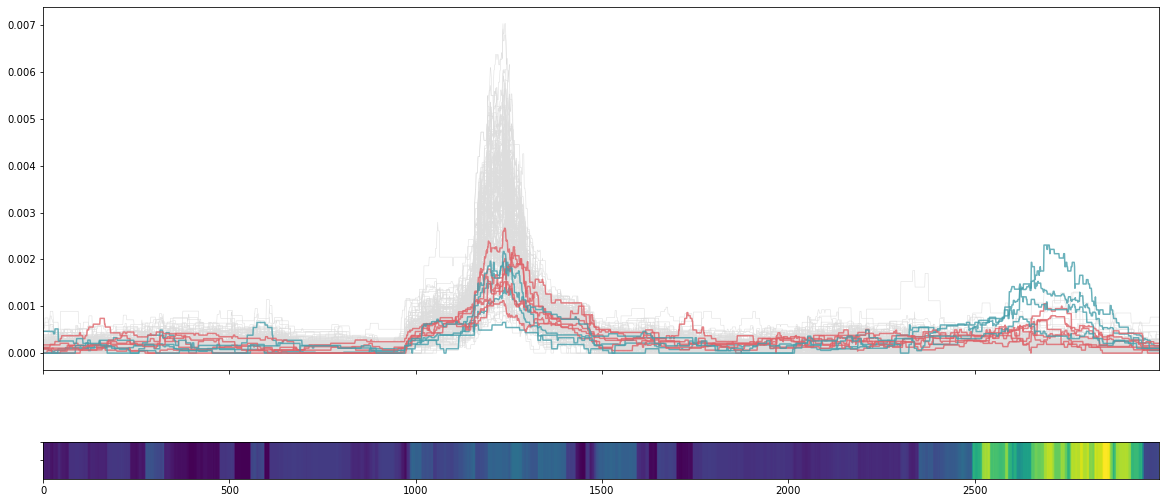

In [103]:
plt.rcParams["figure.figsize"] = (20, 10)

fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1]) 

# Top subplot
ax0 = plt.subplot(gs[0])

for i in range(distribution.shape[0]):
    if metadata.loc[i, 'Cell_type'] != 'Mature_NK':
        ax0.plot(list(range(distribution.shape[1])), distribution[i, :], color="#DDDDDD", linewidth=0.5)

for i in range(distribution.shape[0]):
    if metadata.loc[i, 'Cell_type'] == 'Mature_NK':
        if metadata.loc[i, 'Stimulated']:
            ax0.plot(list(range(distribution.shape[1])), distribution[i, :], color="#DF6369", alpha=0.8)
        else:
            ax0.plot(list(range(distribution.shape[1])), distribution[i, :], color="#469FAB", alpha=0.8)

# Bottom subplot
ax1 = plt.subplot(gs[1], sharex = ax0)
ax1.imshow(cors)
plt.setp(ax0.get_xticklabels(), visible=False)
plt.setp(ax1.get_yticklabels(), visible=False)

plt.subplots_adjust(hspace=0)
plt.show()